In [1]:
from functools import partial
import logging
from collections import OrderedDict

import numpy as np
import scipy.sparse
from osgeo import gdal
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font',size=15)

import proxmin
from proxmin import nmf
from proxmin.operators import prox_soft, get_gradient_x, get_gradient_y
from proxmin.utils import l2
import dc

plogger = logging.getLogger("proxmin")
plogger.setLevel(logging.DEBUG)

points = OrderedDict([
    ("concrete", (162, 507)), # statue
    #("road", (175, 546)), # road, degenerate with concrete
    #("roof2", (114, 575)), # roof, degenerate with dirt
    ("dirt", (172, 597)), # dirt
    ("grass", (125, 575)), #grass
    #("trees", (183, 561)), #tree
    ("bkg", (None,None))
])

#color_cycle = [dc.ref_colors[obj] for obj in points.keys()]
#matplotlib.rcParams['axes.color_cycle'] = color_cycle

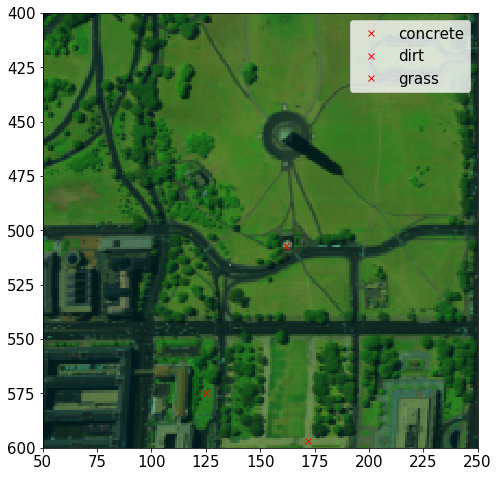

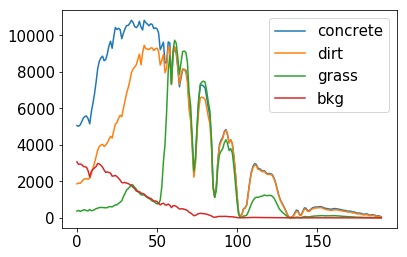

In [2]:
ds = gdal.Open('/Users/fred/Downloads/Hyperspectral_Project/dc.tif')
data_shape = ds.GetRasterBand(1).ReadAsArray().shape

# only use a subset of the image
shape = (ds.RasterCount, data_shape[0]*data_shape[1])

# Get hyperspectral data
data = np.zeros(shape)
for bidx in range(shape[0]):
    band = ds.GetRasterBand(bidx + 1).ReadAsArray()
    data[bidx] = band.flatten()
dc.plot_color_img(data, data_shape, figsize=(8,8), show=False);

# only use a subset of the image
xmin = 50
xmax = 250
ymin = 400
ymax = 600
img_shape = (ymax-ymin, xmax-xmin)
img = data.reshape(data.shape[0], data_shape[0], data_shape[1])[:,ymin:ymax, xmin:xmax]
img = img.reshape(data.shape[0], img_shape[0]*img_shape[1])

spectra = OrderedDict()
for obj, pt in points.items():
    if obj!="bkg":
        plt.plot(pt[0], pt[1],'rx', label=obj)
        spectra[obj] = dc.get_point_spec(pt[0], pt[1], data, data_shape)
    else:
        spectra[obj] = np.min(img, axis=1)

for obj, spec in spectra.items():
    if obj!="bkg":
        spectra[obj] = spec-spectra["bkg"]
plt.legend()
plt.xlim([50,250])
plt.ylim([600,400])
plt.show()

for obj, pt in points.items():
    plt.plot(spectra[obj], label=obj)
plt.legend()
plt.show()

# Get wavelengths used in hyperspectral data
wavelength_data = np.recfromcsv('/Users/fred/Downloads/Hyperspectral_Project/wavelengths.txt', delimiter=" ")
wavelength = wavelength_data["wavelength"]
idx = wavelength_data["idx"]

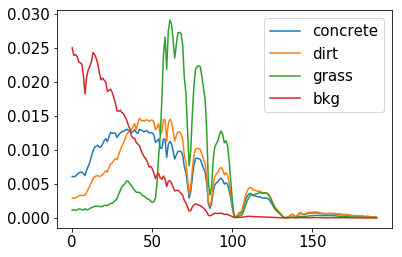

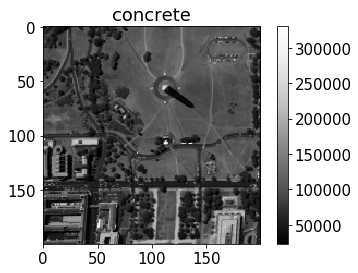

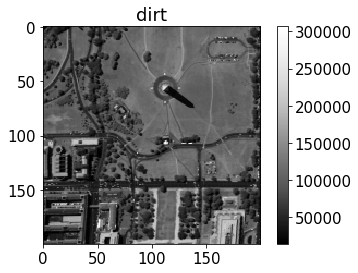

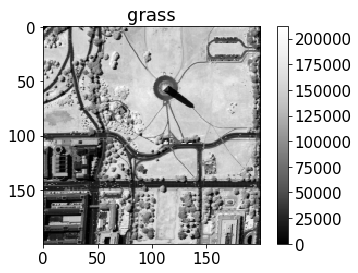

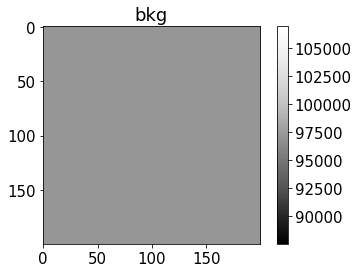

In [3]:
tv_thresh = 10

A0,S0 = dc.init_nmf(
    img,
    img_shape,
    points,
    spectra,
    bidx=-1,
    #show=False,
    features=len(points.keys())
)

prox_A = proxmin.operators.prox_plus
prox_S = proxmin.operators.prox_plus

Lx = get_gradient_x(img_shape, img_shape[1]-1)
Ly = get_gradient_y(img_shape, img_shape[0]-1)
#eye = scipy.sparse.identity(img_shape[0]*img_shape[1])
#Lx_B = scipy.sparse.block_diag([Lx for n in range(S0.shape[0]-1)]+[eye])
#Ly_B = scipy.sparse.block_diag([Ly for n in range(S0.shape[0]-1)]+[eye])
Lx_B = scipy.sparse.block_diag([Lx for n in range(S0.shape[0])])
Ly_B = scipy.sparse.block_diag([Ly for n in range(S0.shape[0])])



Ls = [
    # A constraints
    [np.ones((1,A0.shape[0]))],
    # S constraints
    [
        proxmin.utils.MatrixAdapter(Lx_B, axis=1),
        proxmin.utils.MatrixAdapter(Ly_B, axis=1),
        scipy.sparse.eye(S0.shape[0])
    ]
]
prox_g = [
    # A constraints
    [dc.prox_ones],
    # S constraints
    [
        partial(prox_soft, thresh=tv_thresh),
        partial(prox_soft, thresh=tv_thresh),
        partial(dc.prox_bkg, bidx=-1)
    ]
]

In [4]:
e_rel = 1e-2
e_abs = 0

A, S, hist = nmf.nmf(img,A0, S0,
                     prox_A=prox_A,
                     prox_S=prox_S,
                     Ls=Ls,
                     proxs_g=prox_g,
                     max_iter=300, 
                     traceback=True,
                     update_order=[1,0],
                     e_rel=e_rel,
                     e_abs=e_abs,
                     #steps_g=steps_g
                     #norm_L2 = norm_L2
                     #slack=.1
)

INFO:proxmin.algorithms:Completed 147 iterations


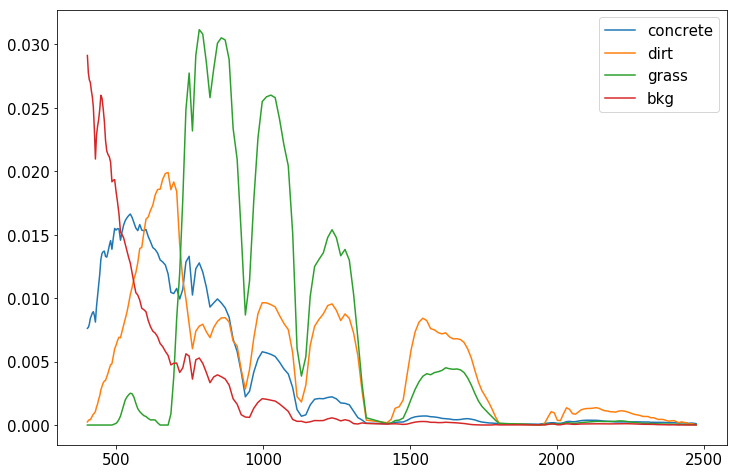

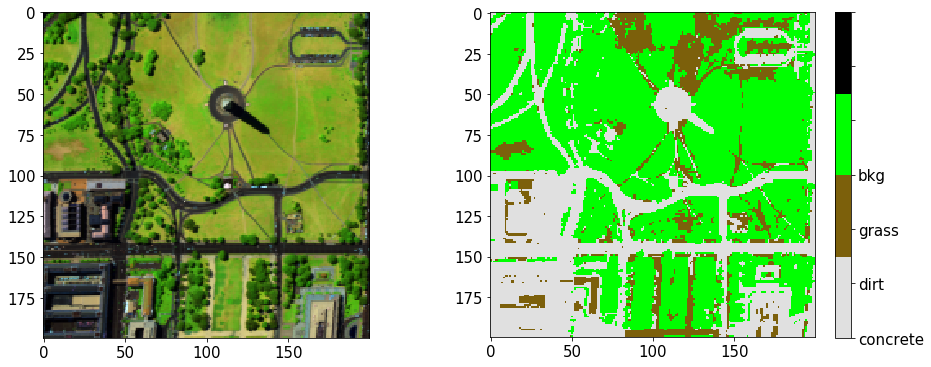

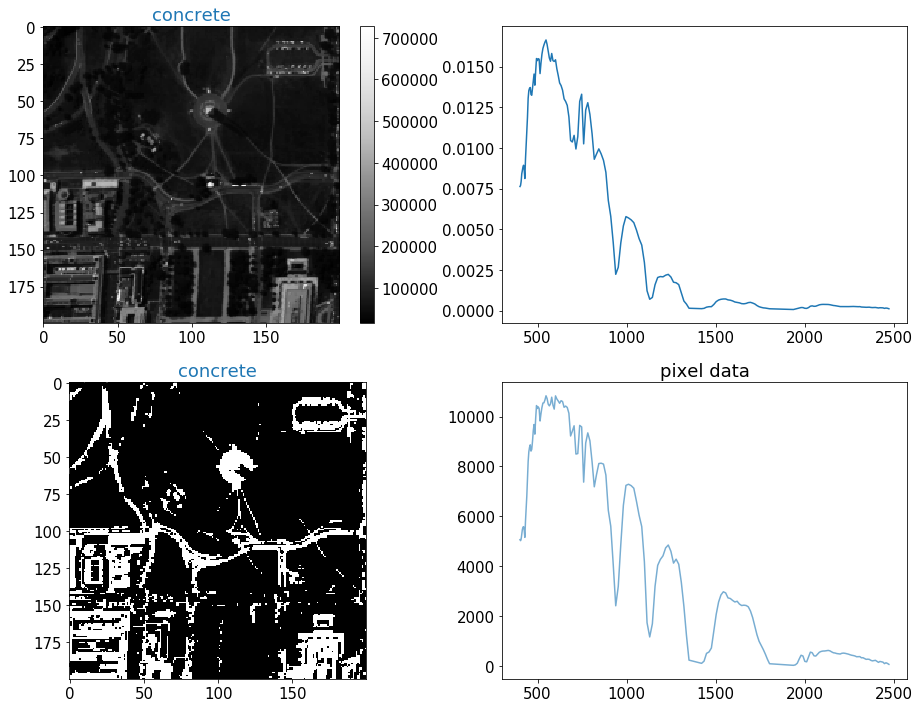

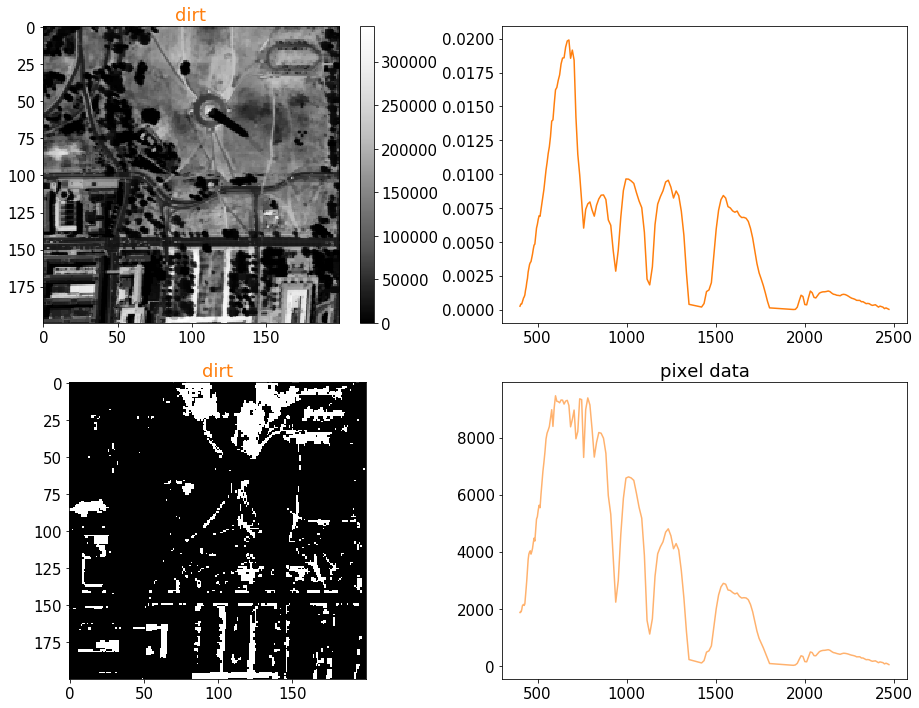

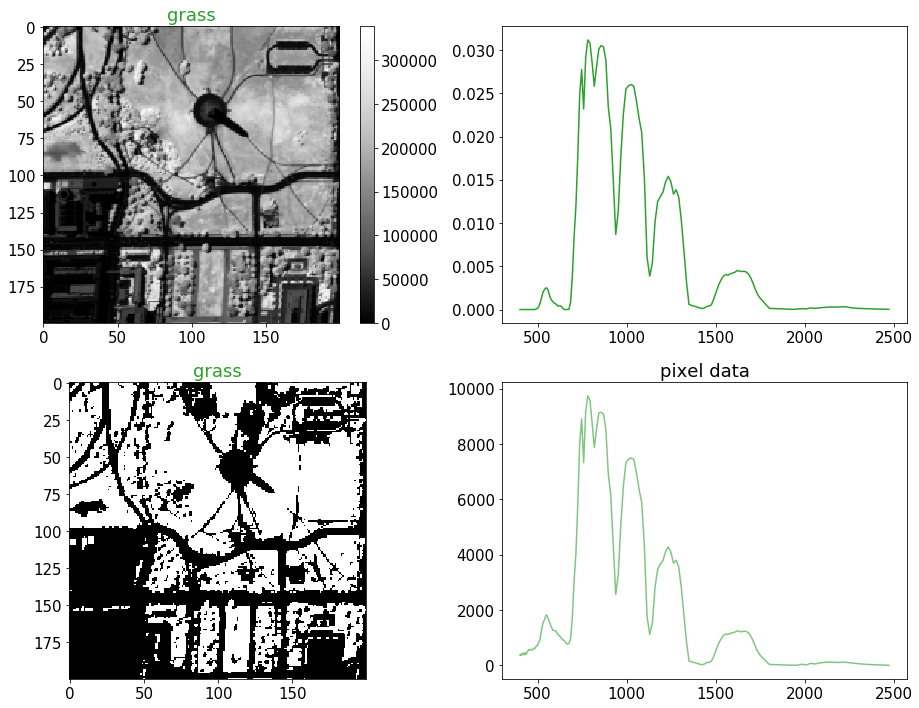

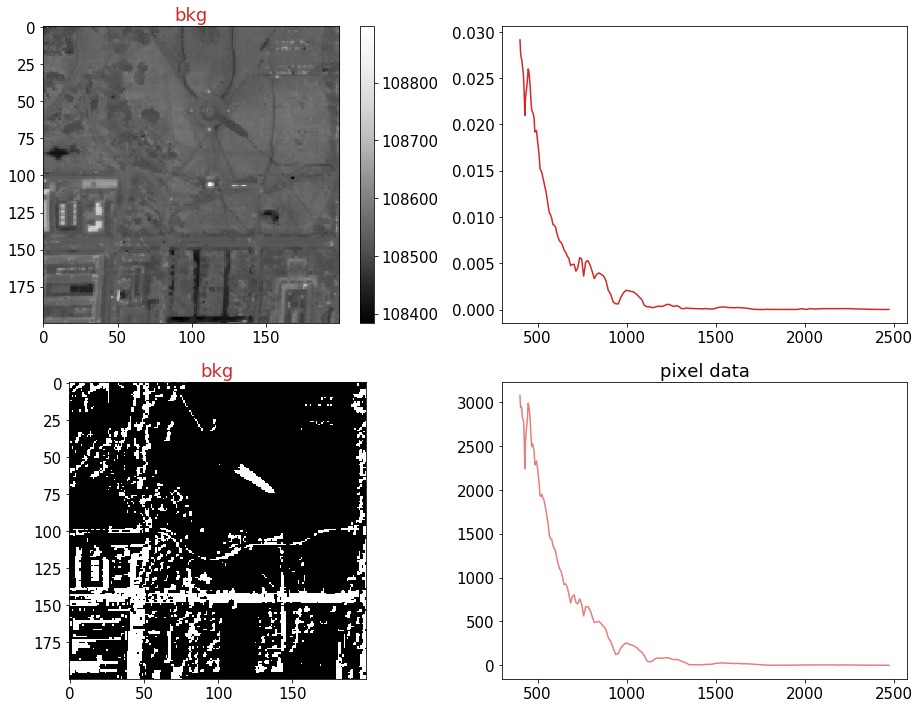

In [5]:
dc.plot_spectra(wavelength, A, points)
dc.compare_likelihood(img, img_shape, S[:-1], points, figsize=(16,6), colors=dc.ref_colors)
dc.plot_objects(img, A, S, img_shape, points, spectra, wavelength=wavelength)

In [6]:
def bounds(img, img_shape, data):
    # get the bounds of the data
    b = np.sum(data[:50], axis=0)
    g = np.sum(data[50:100], axis=0)
    r = np.sum(data[100:], axis=0)
    max_b = np.max(b)
    min_b = np.min(b)
    max_g = np.max(g)
    min_g = np.min(g)
    max_r = np.max(r)
    min_r = np.min(r)
    
    # Map spectra to RGB colors
    b = np.sum(img[:50], axis=0).reshape(img_shape)
    g = np.sum(img[50:100], axis=0).reshape(img_shape)
    r = np.sum(img[100:], axis=0).reshape(img_shape)
    # Set on a scale from 0-255
    b = b-min_b
    g = g-min_g
    r = r-min_r

    b = b/max_b
    g = g/max_g
    r = r/max_r
    return r,g,b

bkg_img = np.zeros_like(data)
for idx in range(A.shape[0]):
    bkg_img[idx, :] = A[idx, -1] * S[-1][0]

f = partial(bounds, data=data-bkg_img)

(191, 40000) (191, 4) (4, 40000)


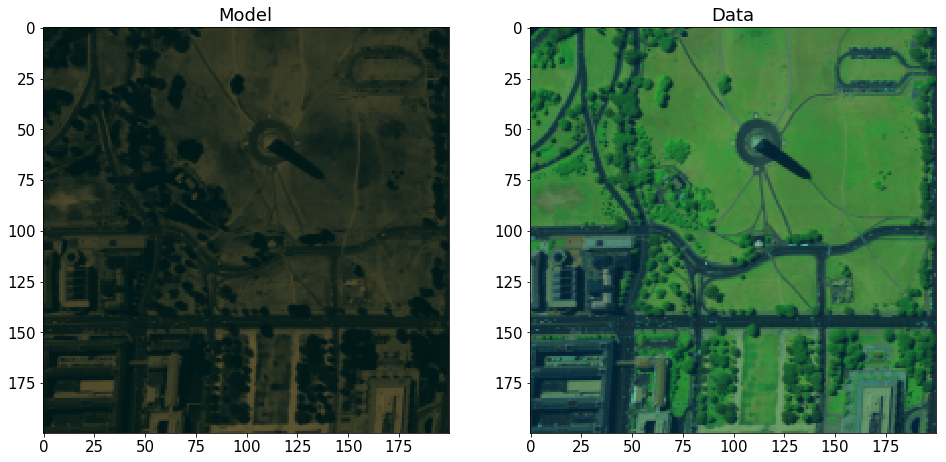

In [7]:
m = np.zeros_like(img)
print(m.shape, A.shape, S.shape)

features = [
    #"concrete",
    "dirt",
    #"grass",

    #"roof2",
    #"trees"
    #"bkg"
]

for sidx in range(A.shape[0]):
    for feature in features:
        idx = list(points.keys()).index(feature)
        m[sidx, :] += A[sidx, idx] * S[idx]

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title("Model")
ax2 = fig.add_subplot(1,2,2)
ax2.set_title("Data")
dc.plot_color_img(m, img_shape, show=False, bounds=f, ax=ax1)
dc.plot_color_img(img, img_shape, show=True, bounds=f, ax=ax2)
plt.show()

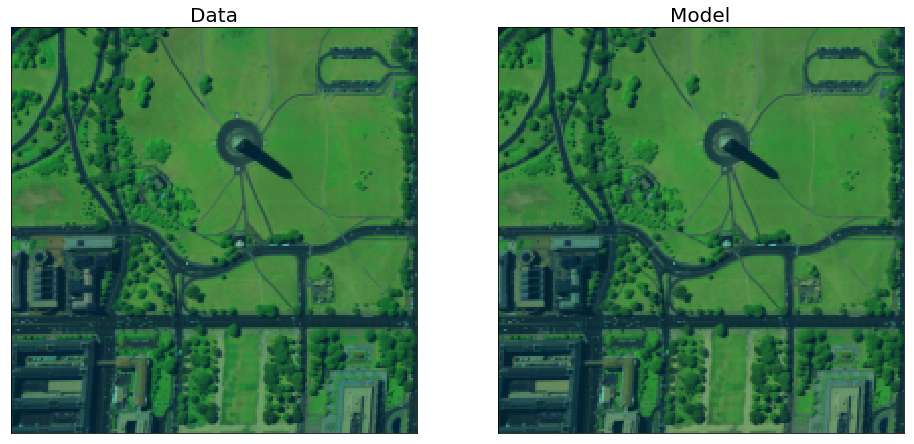

In [8]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.set_title("Data", fontsize=20)
ax2.set_title("Model", fontsize=20)
dc.plot_color_img(img, img_shape, show=False, bounds=f, ax=ax1)
dc.plot_color_img(A.dot(S), img_shape, show=False, bounds=f, ax=ax2)
ax1.xaxis.set_ticks([])
ax1.yaxis.set_ticks([])
ax2.xaxis.set_ticks([])
ax2.yaxis.set_ticks([])

plt.savefig("/Users/fred/projects/glmm_paper/false_color.png", bbox_inches='tight')
plt.show()

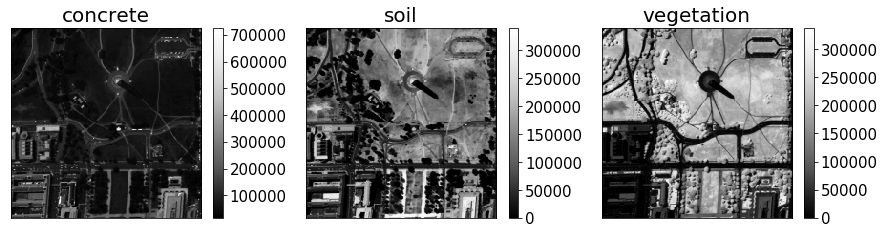

In [9]:
fig = plt.figure(figsize=(15,3.5))
N = len(points.keys())-1
ax = [fig.add_subplot(1,N,n+1) for n in range(N)]
for n in range(N):
    im = ax[n].imshow(S[n].reshape(img_shape), cmap="Greys_r")
    title = list(points.keys())[n]
    if title == "dirt":
        title = "soil"
    elif title == "grass":
        title = "vegetation"
    ax[n].set_title(title, fontsize=20)
    fig.colorbar(im, ax=ax[n])
    ax[n].xaxis.set_ticks([])
    ax[n].yaxis.set_ticks([])
plt.savefig("/Users/fred/projects/glmm_paper/intensity.png", bbox_inches='tight')
plt.show()

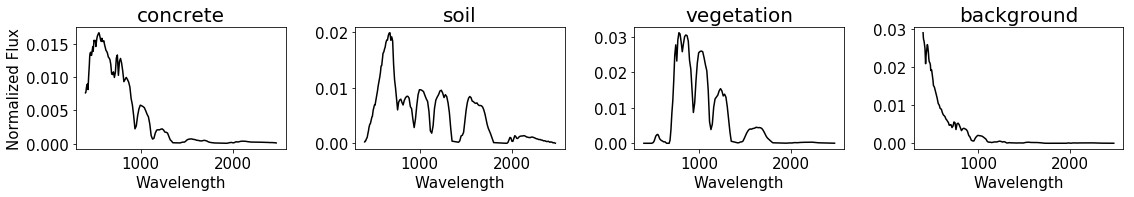

In [23]:
fig = plt.figure(figsize=(16,3))
N = len(points.keys())
ax = [fig.add_subplot(1,N,n+1) for n in range(N)]
for n in range(N):
    title = list(points.keys())[n]
    if title == "dirt":
        title = "soil"
    elif title == "grass":
        title = "vegetation"
    elif title == "bkg":
        title = "background"
    ax[n].plot(wavelength, A[:,n], 'k')
    ax[n].set_title(title, fontsize=20)
    ax[n].set_xlabel("Wavelength")
ax[0].set_ylabel("Normalized Flux")
plt.tight_layout()
plt.savefig("/Users/fred/projects/glmm_paper/spec.eps")#, bbox_inches='tight')
plt.show()

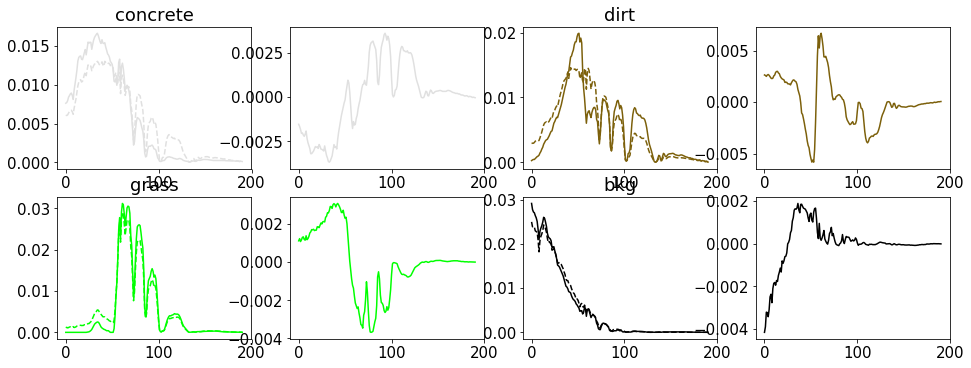

In [11]:
dA = A0-A

fig = plt.figure(figsize=(16,12))
for idx, (obj, pt) in enumerate(points.items()):
    ax1 = fig.add_subplot(4,4,2*idx+1)
    ax2 = fig.add_subplot(4,4,2*idx+2)
    ax1.set_title(obj)
    ax1.plot(A[:,idx], color=dc.ref_colors[obj])
    ax1.plot(A0[:,idx], '--', color=dc.ref_colors[obj])
    ax2.plot(dA[:,idx], color=dc.ref_colors[obj])
plt.show()

In [12]:
Ahist = np.array(hist.history[0]["X"][0])
Shist = np.array(hist.history[1]["X"][0])

In [13]:
model_sum = np.array([np.sum(np.abs(Ahist[n].dot(Shist[n])-img)) for n in range(Ahist.shape[0])])

In [14]:
Ahist = hist.history[0]
Shist = hist.history[1]
e_A = np.array([list(proxmin.utils.get_variable_errors(Ahist["X"][0][i],
                                                       Ls[0][0],
                                                       Ls[0][0].dot(Ahist["X"][0][i]),
                                                       Ahist["Z"][0][i],
                                                       Ahist["U"][0][i],                                                       
                                                       Ahist["steps_g"][0][i],
                                                       e_rel,
                                                       e_abs))
                for i in range(1,len(Ahist["X"][0])-1)])
e_pri2A = e_A[:,0]
e_dual2A = e_A[:,1]

s_vars = ["TV(X)", "TV(Y)","Background"]
e_priS = {}
e_dualS = {}
for j,L in enumerate(Ls[1]):
    e_S = np.array([list(proxmin.utils.get_variable_errors(Shist["X"][0][i],
                                                       L,
                                                       L.dot(Shist["X"][0][i]),
                                                       Shist["Z"][j][i],
                                                       Shist["U"][j][i],
                                                       Shist["steps_g"][j][i],
                                                       e_rel,
                                                       e_abs))
                for i in range(1,len(Shist["X"][0])-1)])
    e_priS[s_vars[j]] = e_S[:,0]
    e_dualS[s_vars[j]] = e_S[:,1]

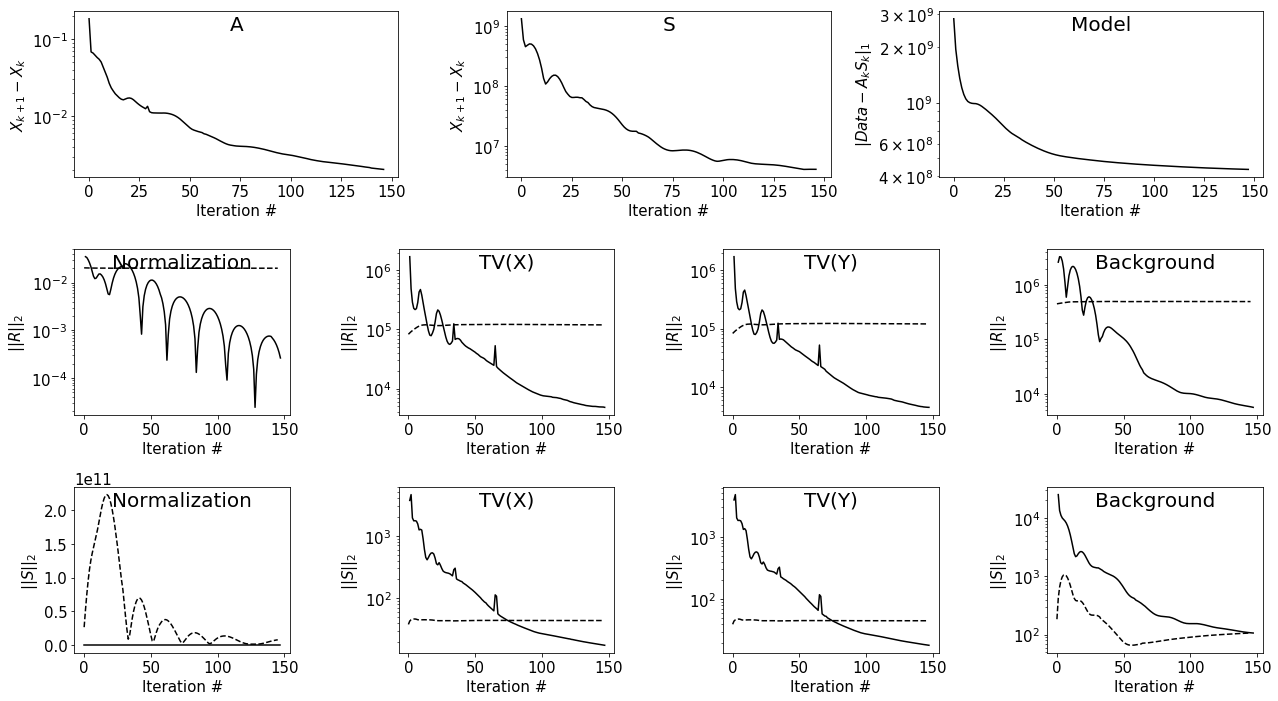

In [22]:
histories = [("A",0,0,"X"), ("S",1,0,"X"), ("Model",None,None,None),
             #("Normalization",0,0,"Z"), ("TV(X)",1,0,"Z"), ("TV(Y)",1,1,"Z"), ("Background",1,2,"Z"),
             ("Normalization",0,0,"R"), ("TV(X)",1,0,"R"), ("TV(Y)",1,1,"R"), ("Background",1,2,"R"),
             ("Normalization",0,0,"S"), ("TV(X)",1,0,"S"), ("TV(Y)",1,1,"S"), ("Background",1,2,"S")]

fig = plt.figure(figsize=(18,10))
#axes = [fig.add_subplot(2,3,n+1) for n in range(3)]+[fig.add_subplot(2,4,n+5) for n in range(4)]
#axes = [fig.add_subplot(2,3,n+1) for n in range(3)]+[fig.add_subplot(3,4,n+9) for n in range(4)]
"""axes = [
    plt.subplot2grid((7, 12), (0, 0), colspan=4, rowspan=4),
    plt.subplot2grid((7, 12), (0, 4), colspan=4, rowspan=4),
    plt.subplot2grid((7, 12), (0, 8), colspan=4, rowspan=4),
    plt.subplot2grid((7, 12), (4, 0), colspan=3, rowspan=3),
    plt.subplot2grid((7, 12), (4, 3), colspan=3, rowspan=3),
    plt.subplot2grid((7, 12), (4, 6), colspan=3, rowspan=3),
    plt.subplot2grid((7, 12), (4, 9), colspan=3, rowspan=3),
]"""

rows = 3
axes = [
    plt.subplot2grid((rows, 12), (0, 0), colspan=4),
    plt.subplot2grid((rows, 12), (0, 4), colspan=4),
    plt.subplot2grid((rows, 12), (0, 8), colspan=4),
    #plt.subplot2grid((rows, 12), (1, 0), colspan=3),
    #plt.subplot2grid((rows, 12), (1, 3), colspan=3),
    #plt.subplot2grid((rows, 12), (1, 6), colspan=3),
    #plt.subplot2grid((rows, 12), (1, 9), colspan=3),
    plt.subplot2grid((rows, 12), (rows-2, 0), colspan=3),
    plt.subplot2grid((rows, 12), (rows-2, 3), colspan=3),
    plt.subplot2grid((rows, 12), (rows-2, 6), colspan=3),
    plt.subplot2grid((rows, 12), (rows-2, 9), colspan=3),
    plt.subplot2grid((rows, 12), (rows-1, 0), colspan=3),
    plt.subplot2grid((rows, 12), (rows-1, 3), colspan=3),
    plt.subplot2grid((rows, 12), (rows-1, 6), colspan=3),
    plt.subplot2grid((rows, 12), (rows-1, 9), colspan=3),
]

def l2hist(X):
    return np.sqrt(np.sum(X**2, axis=(1,2)))

for n, (key, i, j, v) in enumerate(histories):
    ax = axes[n]
    if i is not None:
        myhist = np.array(hist.history[i][v][j])
        if v=="Z" or v=="X":
            ax.semilogy(np.sum(np.abs(myhist[1:]-myhist[:-1]), axis=(1,2)), "k")
            ax.set_ylabel("${0}_{{k+1}}-{0}_{{k}}$".format(v))
        else:
            ax.set_ylabel("$||{0}||_2$".format(v))
            if i==0:
                if v=="R":
                    ax.semilogy(l2hist(myhist), "k")
                    ax.plot(e_pri2A, 'k--')
                else:
                    ax.plot(l2hist(myhist), "k")
                    ax.plot(e_dual2A, "k--")
            else:
                ax.semilogy(l2hist(myhist), "k")
                if v=="R":
                    ax.plot(e_priS[key], 'k--')
                else:
                    ax.plot(e_dualS[key], "k--")
    else:
        ax.semilogy(model_sum, "k")
        ax.set_ylabel("$|Data-A_{{k}}S_{{k}}|_{{1}}$")
    ax.set_title(key, y=.85, fontsize=20)
    ax.set_xlabel("Iteration #")
plt.tight_layout()
plt.savefig("/Users/fred/projects/glmm_paper/convergence.eps")#, bbox_inches='tight')
plt.show()

[  1.80245001e-13   1.79913508e-13   1.79913508e-13   1.79913508e-13
   1.79913508e-13   1.79913508e-13   1.79913508e-13   1.79913508e-13
   1.79913508e-13   1.79913508e-13   1.79913508e-13   1.79913508e-13
   1.79913508e-13   1.79913508e-13   1.79913508e-13   1.79913508e-13
   1.79913508e-13   1.79913508e-13   1.79913508e-13   1.79913508e-13
   1.79913508e-13   1.79913508e-13   1.79913508e-13   1.79913508e-13
   1.79913508e-13   1.79913508e-13   1.79913508e-13   1.79913508e-13
   1.79913508e-13   1.68995052e-13   1.68995052e-13   1.68995052e-13
   1.68995052e-13   1.68995052e-13   1.68995052e-13   1.68995052e-13
   1.68995052e-13   1.68995052e-13   1.68995052e-13   1.68995052e-13
   1.68995052e-13   1.68995052e-13   1.68995052e-13   1.68995052e-13
   1.68995052e-13   1.68995052e-13   1.68995052e-13   1.68995052e-13
   1.68995052e-13   1.68995052e-13   1.68995052e-13   1.68995052e-13
   1.68995052e-13   1.68995052e-13   1.68995052e-13   1.68995052e-13
   1.68995052e-13   1.73360411e-13

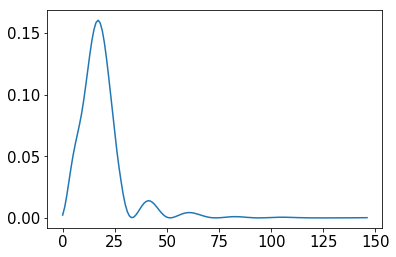

In [16]:
rho = np.array(Ahist["steps_g"][0][1:])
print(rho)
#lu = np.array([1/rho[i] * Ls[0][0].T.dot(u) for i,u in enumerate(Ahist["U"][0][1:])])
lu = np.array([Ls[0][0].T.dot(u) for i,u in enumerate(Ahist["U"][0][1:])])
plt.plot(np.sum(e_rel*lu**2, axis=(1,2)))

0 [568.88259525582123, 560.92876292869755, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 561.86231597601113, 594.8674497162333, 594.8674497162333, 594.8674497162333, 594.8674497162333, 594.8674497162333, 594.8674497162333, 594.8674497162333, 594.8674497162333, 594.8674497162333, 594.8674497162333, 594.8674497162333, 594.8674497162333, 594.8674497162333, 594.8674497162333, 594.8674497162333, 594.8674497162333, 594.8674497162333, 594.8674497162

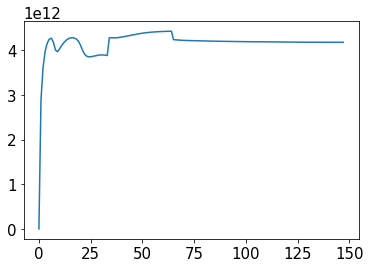

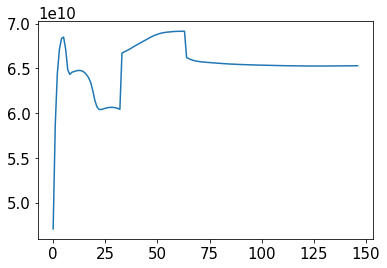

1 [568.88259525582384, 560.92876292870017, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 561.86231597601363, 594.86744971623602, 594.86744971623602, 594.86744971623602, 594.86744971623602, 594.86744971623602, 594.86744971623602, 594.86744971623602, 594.86744971623602, 594.86744971623602, 594.86744971623602, 594.86744971623602, 594.86744971623602, 594.86744971623602, 594.86744971623602, 594.86744971623602, 594.86744971623602, 594.8674497162360

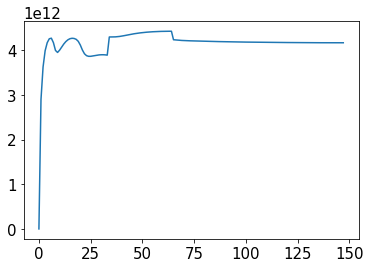

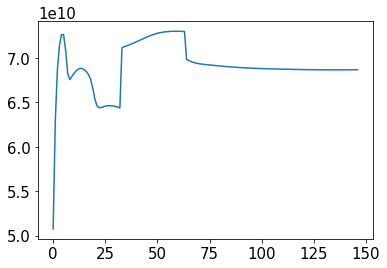

2 [142.22942205937247, 140.24084131445579, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 140.47424397343758, 148.72603641007052, 148.72603641007052, 148.72603641007052, 148.72603641007052, 148.72603641007052, 148.72603641007052, 148.72603641007052, 148.72603641007052, 148.72603641007052, 148.72603641007052, 148.72603641007052, 148.72603641007052, 148.72603641007052, 148.72603641007052, 148.72603641007052, 148.72603641007052, 148.7260364100705

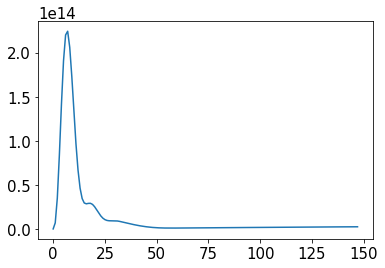

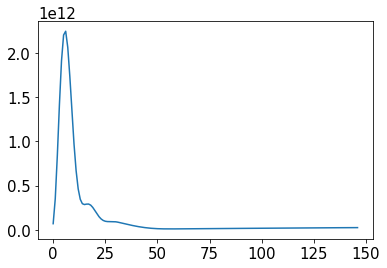

In [17]:
for i, rho in enumerate(Shist["steps_g"]):
    print(i, rho[1:])
    plt.plot(np.sum(np.array(Shist["U"][i])**2, axis=(1,2)))
    plt.show()
    lu = np.array([Ls[1][i].T.dot(u) for u in Shist["U"][i][1:]])
    plt.plot(np.sum(e_rel*lu**2, axis=(1,2)))
    plt.show()